# DAS Denoising - Application to NGL DAS VSP Data
Apply trained models to weight drop dataset acquired with Silixa iDAS v2. Several models are in the models folder. Models need to be changed in the model input cell.

Notebook steps: 
- [Load Packages and Scripts](#load_packages)
- [Set Display and Export Parameters](#set_param)
- [Load Data](#load_data)
- [Load Model](#load_model)
- [Preprocess Data](#data_preprocessing)
- [Run Model](#run_model)
- [Compute Signal to Noise Ratio](#compute_SNR)
- [Plot Figures](#plot_fig)

<a id=load_packages></a>
## Load Packages and Scripts

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [2]:
import tensorflow as tf
from tensorflow.keras.models import *
# Tensorflow version
print('TensorFlow version:',tf.__version__)
# Set gpu memory if gpu is available
gpu = tf.config.list_physical_devices('GPU') # Check GPU available
print(gpu)
if gpu: 
    tf.config.experimental.set_memory_growth(gpu[0], True)

TensorFlow version: 2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Import functions for data loading and signal to noise computations

In [3]:
# Import local scripts
from Utils.RP_Proc import fCalcFrameSNR, fCalcSNR2DFrame
from Utils.apply_nn import fDenoiseDAS

## Set Input Model

In [4]:
# model_path = r'Models\Silixa\N2N_LowPowerSourceTest_30ep_v10_patch128x96_dgtarget_fliplr.h5'
# model_path = r'Models\Silixa\Supervised_Otway_100Shots_250Epochs0.8_3_Nnet4.h5'
model_path = r'Models\Silixa\Unit100Shots250Epochs0.8_3_Nnet4.h5'

<a id=set_param></a>
## Set Display and Export Parameters

In [5]:
# Plot parameters
plt.rc('axes',labelsize=14)
plt.rc('font',size=14)
plt.rc('xtick',labelsize='medium')
plt.rc('ytick',labelsize='medium')
plt.rc('grid', linestyle=':', linewidth=0.5)
interpolation_opt = 'sinc'
c_map = 'seismic'
v_max = 50

In [6]:
# Optional pre-processing steps
apply_detrend = False
apply_ringDownRemoval = False

## Load Data

In [7]:
# List files in data directory
data_path = r'Data\Silixa'
npy_files = [os.path.join(data_path,x) for x in os.listdir(data_path) if '.npy' in x]
npy_files

['Data\\Silixa\\Silixa_Data_Example.npy']

In [8]:
# Load data
dt = 0.001
D = np.load(npy_files[0])
# Check size
np.shape(D)

(798, 759)

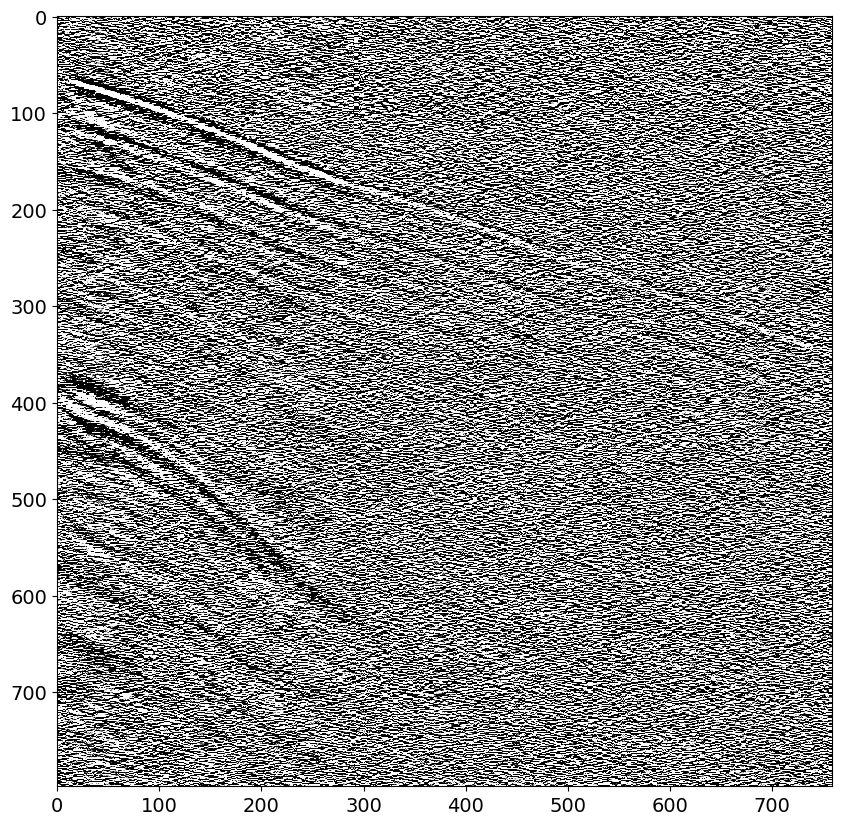

In [9]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
mD = np.amax(np.abs(D))
a = 0.005 # scaler for plotting
ax.imshow(D, interpolation='sinc', aspect='auto', cmap='gray', 
          vmin=-a*mD, vmax=a*mD)
plt.show()

## Load Model

In [10]:
os.getcwd()

'C:\\Users\\253863J\\OneDrive - Curtin\\Jupyter_Sharing\\DenoisingDAS_MinEx'

In [11]:
#### LOAD MODELS ####
dasn2n = load_model(model_path) # DAS-N2N

In [12]:
dasn2n.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 96)]    0           []                               
                                                                                                  
 reshape (Reshape)              (None, 128, 96, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 96, 24)  240         ['reshape[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 96, 24)  0           ['conv2d[0][0]']                 
                                                                                              

## Apply Denoising

In [13]:
%%time
st_array_out = fDenoiseDAS(D, dasn2n, 
                           apply_detrend=apply_detrend, apply_ringDownRemoval=apply_ringDownRemoval)

Extracting 195 patches
wHann_submatrices[128, 96]
(1, 896, 768)
CPU times: total: 2.95 s
Wall time: 2.91 s


<a id=psd></a>
## Power Spectral Density

In [14]:
def spectral_density(strr_in, dt):
    n_time = strr_in.shape[0]
    f,Pxx = signal.welch(strr_in, fs = 1/dt, axis = 0, detrend = 'constant', nperseg = int(n_time/2))
    Px = np.mean(Pxx,axis=1)
    Px = np.sqrt(Px)
    return f, Px

In [15]:
f, Px_noisy = spectral_density(D, dt) #input
f, Px_denoised = spectral_density(st_array_out, dt) #denoised
f, Px_noise = spectral_density(st_array_out-D, dt) #removed noise

<a id=compute_SNR></a>
## Compute Signal to Noise Ratio

SNR frame values

In [16]:
maxlag = 0.1 #(in s)
percent = 30;
snr_frame_in = fCalcFrameSNR(D,percent,np.ceil(maxlag/dt).astype(int))
snr_frame_out = fCalcFrameSNR(st_array_out,percent,np.ceil(maxlag/dt).astype(int))
snr_frame_noise = fCalcFrameSNR(D-st_array_out,percent,np.ceil(maxlag/dt).astype(int))

In [17]:
print(snr_frame_in, snr_frame_out, snr_frame_noise)

2.056202336832365 4.698219518857808 1.9804013183882008


SNR sections

In [18]:
%%time
window = 30
snr_in = fCalcSNR2DFrame(D,window)
snr_out = fCalcSNR2DFrame(st_array_out,window)
snr_noise = fCalcSNR2DFrame(st_array_out-D,window)

CPU times: total: 17 s
Wall time: 17.1 s


<a id=plot_fig></a>
## Plot Figures

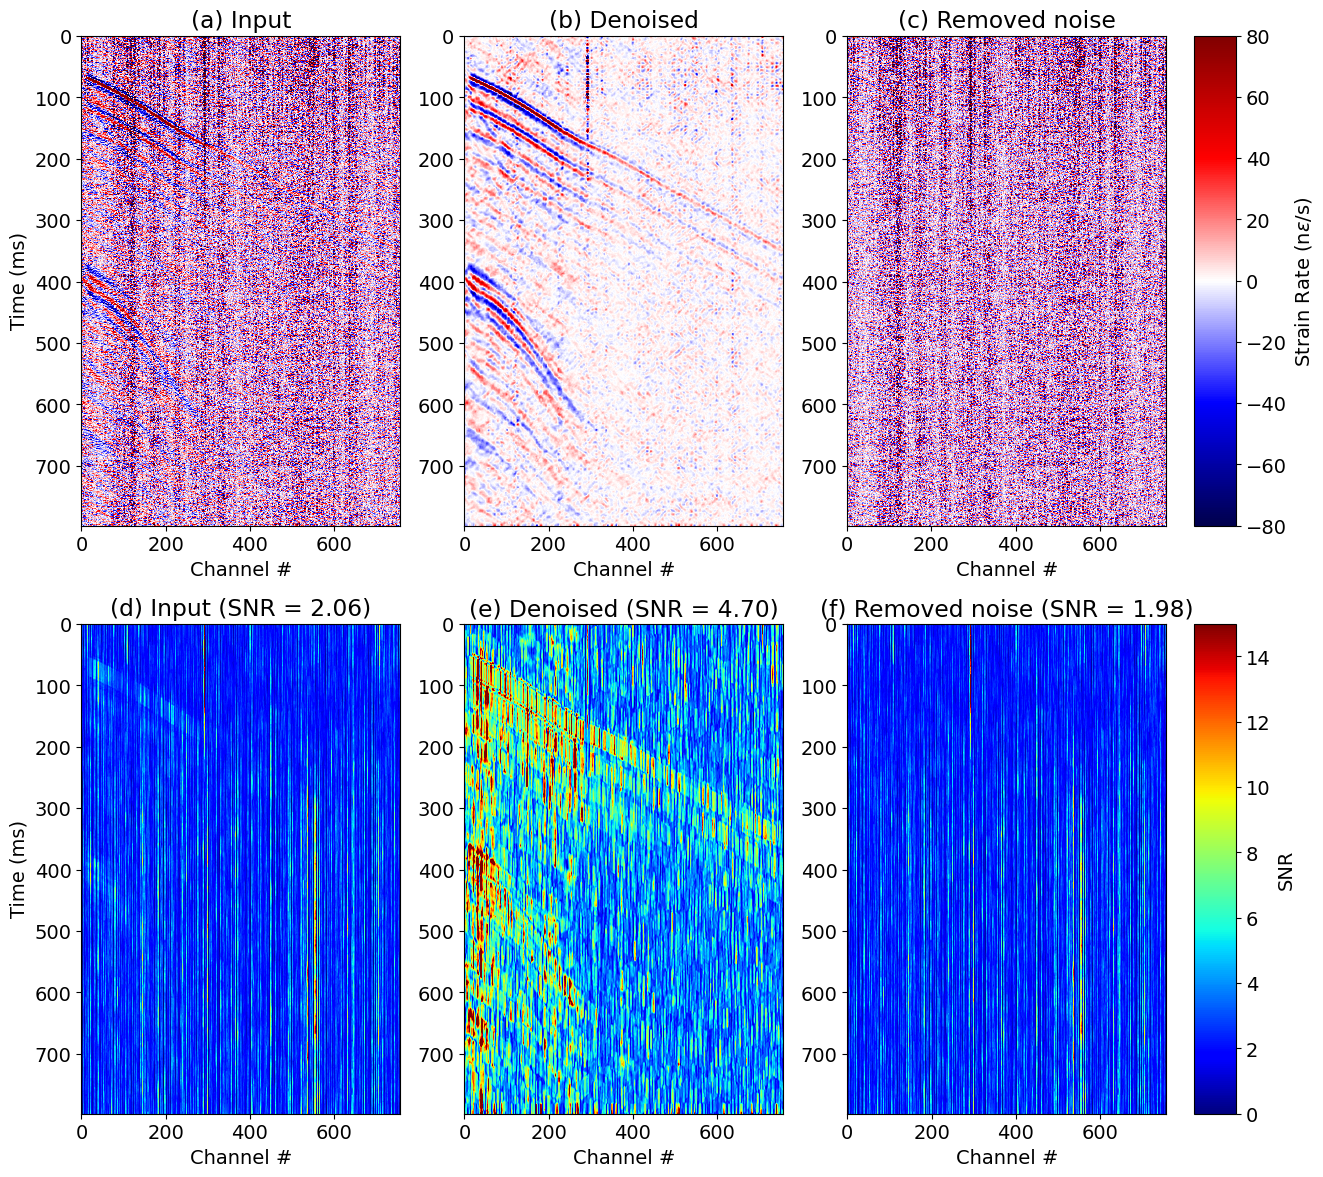

In [19]:
if True:
    fig, axs = plt.subplots(2,3,figsize=(14,14))
    v_max = 80
    #--1st row: gathers
    axs[0,0].imshow(D[0:800,:], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                  vmin=-v_max, vmax=v_max)
    axs[0,0].set(title='(a) Input', xlabel='Channel #', ylabel='Time (ms)')
    axs[0,1].imshow(st_array_out[0:800,:], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                 vmin=-v_max, vmax=v_max)
    axs[0,1].set(title='(b) Denoised', xlabel='Channel #')
    im = axs[0,2].imshow(D[0:800,:]-st_array_out[0:800,:], interpolation=interpolation_opt, aspect='auto', cmap=c_map,
                 vmin=-v_max, vmax=v_max)
    axs[0,2].set(title='(c) Removed noise', xlabel='Channel #')
    # Add single colorbar to the right
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.53, 0.03, 0.35])
    fig.colorbar(im, cax=cbar_ax, label='Strain Rate (n$\epsilon$/s)')
    #--2nd row: SNR sections
    v_snr = 15
    axs[1,0].imshow(snr_in, interpolation=interpolation_opt, aspect='auto', cmap='jet', vmin=0, vmax=v_snr)
    axs[1,0].set(title='(d) Input (SNR = {:.02f})'.format(snr_frame_in), xlabel='Channel #', ylabel='Time (ms)')
    pcm = axs[1,1].imshow(snr_out, interpolation=interpolation_opt, aspect='auto', cmap='jet', vmin=0, vmax=v_snr)
    axs[1,1].set(title='(e) Denoised (SNR = {:.02f})'.format(snr_frame_out), xlabel='Channel #')
    im2 = axs[1,2].imshow(snr_noise, interpolation=interpolation_opt, aspect='auto', cmap='jet', vmin=0, vmax=v_snr)
    axs[1,2].set(title='(f) Removed noise (SNR = {:.02f})'.format(snr_frame_noise), xlabel='Channel #')
    # Add single colorbar to the right
    fig.subplots_adjust(right=0.9)
    cbar_ax2 = fig.add_axes([0.92, 0.11, 0.03, 0.35])
    fig.colorbar(im2, cax=cbar_ax2, label='SNR')
    plt.show()    

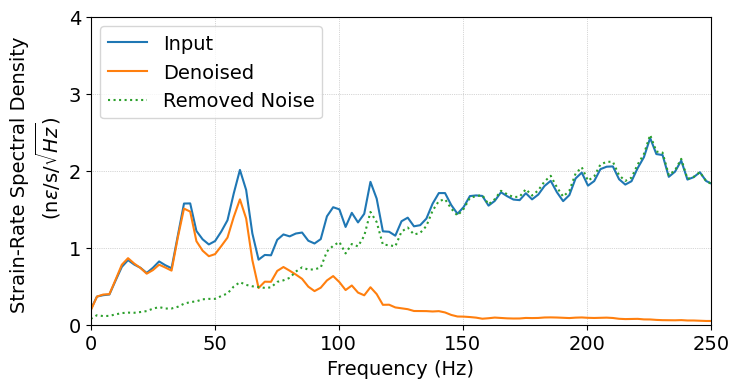

In [20]:
if True:
    fig = plt.figure(figsize=(8,4))
    ax = plt.axes()
    ax.plot(f, Px_noisy, label='Input')
    ax.plot(f, Px_denoised, label='Denoised')
    ax.plot(f, Px_noise, ':', label='Removed Noise')
    ax.set(xlabel='Frequency (Hz)', 
           ylabel='Strain-Rate Spectral Density \n (n$\epsilon$/s/$\sqrt{Hz}$)',
           xscale='linear', yscale='linear', xlim=[0,250], ylim=[0,4])
    ax.legend(loc='upper left')
    ax.grid(which='both')
    plt.show()